<h3>
<center>
Basic Finance <br/>
by <br/>
Ian Kaplan
</center>
</h3>

<p>
The Python code in this Jupyter notebook demonstrates some basic quantiative
finance code.
</p>
<p>
I have a Masters degree in Computational Finance and Risk Management from the
University of Washington.  In this Masters program we used R.  I also used
R for my Masters degree project (see
<a href="http://bearcave.com/finance/thesis_project/index.html">Value Factors Do Not Forecast Returns for S&P 500 Stocks</a>)
</p>
<p>
For a variety of reasons I am moving from R to Python.  This notebook contains some of the
first steps in this journey.
</p>
<p>
The symbol ^IRX is the symbol for the 13-week t-bill, expressed as a yearly rate. This is used
as a proxy for the "risk free rate".
</p>

In [35]:
from typing import List
from pandas_datareader import data
from tabulate import tabulate
import pandas as pd
import numpy as np
from pathlib import Path
import statistics as stat
import matplotlib.pyplot as plt

tickers = ['gs', 'jpm', 'bac']

risk_free_asset = '^IRX'

print("Symbols: " + " ".join(sym + ' ' for sym in tickers))

Symbols: gs  jpm  bac 


<p>
Fetch adjusted daily close prices for the symbols
</p>
<p>
To avoid repeatedly accessing the data source, the close price data is written to a file in /tmp.
This file will be removed when the system is rebooted.
</p>

In [36]:
data_source = 'yahoo'

# year-month-day
start_date = '2019-01-01'
end_date = '2021-10-05'

tempRoot: str = '/tmp/'
stockFileName: str = 'banks.csv'
stockFilePath: str = tempRoot + stockFileName
stockTempPath = Path(stockFilePath)
if stockTempPath.exists():
    fileSize = stockTempPath.stat().st_size

fileSize = 0
if fileSize > 0:
    close_prices = pd.read_csv(stockFilePath, index_col='Date')
else:
    panel_data = data.DataReader(tickers, data_source, start_date, end_date)
    close_prices = panel_data['Adj Close']
    close_prices.to_csv(stockFilePath)

rfFileName = "risk_free.csv"
rfFilePath = tempRoot + rfFileName
rfTempPath = Path(rfFilePath)

fileSize = 0
if rfTempPath.exists():
    fileSize = rfTempPath.stat().st_size

if fileSize > 0:
    rf_prices = pd.read_csv(rfFilePath, index_col='Date')
else:
    panel_data = data.DataReader(risk_free_asset, data_source, start_date, end_date)
    rf_prices = panel_data['Adj Close']
    rf_prices.to_csv(rfFilePath)

<h3>
Basic time series statistics
</h3>

<h4>
Stocks
</h4>

In [37]:
print(tabulate(close_prices.describe(), headers=['Statistics', *tickers], tablefmt="fancy_grid"))

╒══════════════╤══════════╤══════════╤═══════════╕
│ Statistics   │       gs │      jpm │       bac │
╞══════════════╪══════════╪══════════╪═══════════╡
│ count        │ 696      │ 696      │ 696       │
├──────────────┼──────────┼──────────┼───────────┤
│ mean         │ 240.461  │ 117.073  │  29.9886  │
├──────────────┼──────────┼──────────┼───────────┤
│ std          │  73.6739 │  24.2521 │   6.23185 │
├──────────────┼──────────┼──────────┼───────────┤
│ min          │ 131.002  │  74.87   │  17.4691  │
├──────────────┼──────────┼──────────┼───────────┤
│ 25%          │ 190.829  │  96.6993 │  25.3222  │
├──────────────┼──────────┼──────────┼───────────┤
│ 50%          │ 204.868  │ 108.12   │  27.9751  │
├──────────────┼──────────┼──────────┼───────────┤
│ 75%          │ 290.02   │ 135.584  │  33.5886  │
├──────────────┼──────────┼──────────┼───────────┤
│ max          │ 417.661  │ 168.66   │  44.22    │
╘══════════════╧══════════╧══════════╧═══════════╛


<h4>
Risk-free asset
</h4>

In [38]:
print(tabulate(rf_prices.describe(), headers=['Statistics', risk_free_asset], tablefmt="fancy_grid"))

╒══════════════╤════════════╕
│ Statistics   │       ^IRX │
╞══════════════╪════════════╡
│ count        │ 692        │
├──────────────┼────────────┤
│ mean         │   0.867475 │
├──────────────┼────────────┤
│ std          │   0.966755 │
├──────────────┼────────────┤
│ min          │  -0.105    │
├──────────────┼────────────┤
│ 25%          │   0.045    │
├──────────────┼────────────┤
│ 50%          │   0.115    │
├──────────────┼────────────┤
│ 75%          │   1.9      │
├──────────────┼────────────┤
│ max          │   2.408    │
╘══════════════╧════════════╛


<h3>
Time series plots
</h3>

<AxesSubplot:xlabel='Date'>

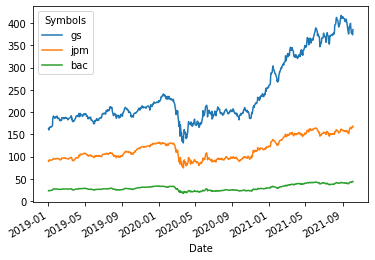

In [39]:
close_prices.plot()

<p>
Comparing the three bank stocks is difficult since they are on different scales.
Normalizing each stock price so that it starts at one allows price
increases/decreases for the stocks to be compared on the same scale.
</p>
<p>
One way to view this plot is the return on one dollar invested in each of the three
bank stocks.
</p>

<AxesSubplot:xlabel='Date'>

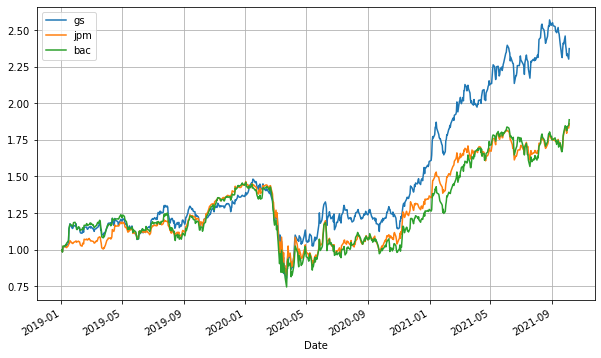

In [40]:
normalized_close_list: List = []
for sym in tickers:
    normalized = close_prices[sym] / close_prices[sym][0]
    normalized_close_list.append(normalized)

normalized_close = pd.DataFrame(normalized_close_list).transpose()

normalized_close.plot(grid=True, figsize=(10,6))

The above plot shows that Goldman Sachs (gs) is a dramatically better investment
than either Bank of America or JP Morgan.

<h3>
Simple return
</h3>

$\ R = \large \frac{R_t - R_{t-1}}{R_{t-1}} = \frac{R_t}{R_{t-1}} - 1$


In [41]:
def simple_return(time_series: List) -> List :
    return list(((time_series[i]/time_series[i-1]) - 1.0 for i in range(1, len(time_series))))

def return_df(time_series_df: pd.DataFrame) -> pd.DataFrame:
    """
    Given a data frame consisting of price time series, return a data frame
    that consists of the simple returns for the time series.  The returned data
    frame will have the same columns, but the time index will be one time period
    less.
    """
    r_df: pd.DataFrame = pd.DataFrame()
    col_names = time_series_df.columns
    index = time_series_df.index
    for col in col_names:
        col_vals = time_series_df[col]
        col_ret = simple_return(col_vals)
        r_df[col] = col_ret
    return r_df.set_index(index[1:len(index)])

def excess_return_series(asset_return: pd.Series, risk_free: pd.Series) -> pd.DataFrame:
    excess_ret_list: List = []
    for i, ret in enumerate(asset_return):
        excess_ret_list.append(ret - risk_free[i])
    return pd.DataFrame(excess_ret_list).set_index(asset_return.index)


def excess_return_df(asset_return: pd.DataFrame, risk_free: pd.Series) -> pd.DataFrame:
    excess_df: pd.DataFrame = pd.DataFrame()
    for i, col in enumerate(asset_return.columns):
        e_df = excess_return_series(asset_return[col], risk_free)
        excess_df.insert(i, col, e_df)
    return excess_df

def calc_sharpe_ratio(asset_return: pd.DataFrame, risk_free: pd.Series) -> pd.DataFrame:
    excess_return = excess_return_df(asset_return, risk_free)
    return_mean: List = []
    return_stddev: List = []
    for col in excess_return.columns:
        mu = stat.mean(excess_return[col])
        std = stat.stdev(excess_return[col])
        return_mean.append(mu)
        return_stddev.append(std)
    # daily Sharpe ratio
    # https://quant.stackexchange.com/questions/2260/how-to-annualize-sharpe-ratio
    sharpe_ratio = np.asarray(return_mean) / np.asarray(return_stddev)
    result_df: pd.DataFrame = pd.DataFrame(sharpe_ratio).transpose()
    result_df.columns = asset_return.columns
    ix = asset_return.index
    ix_start = ix[0].date()
    ix_end = ix[len(ix)-1].date()
    index_str = f'{ix_start} : {ix_end}'
    result_df.index = [ index_str ]
    return result_df

<p>
To calculate the Sharpe ratio below each close price must correspond to a risk free rate price.
The data description tables above show that the number of stock close prices and
risk free prices do not match.   Presumably this is due to
risk-free asset (e.g., US treasury bills) values not being reported on bank holidays
that are not holidays shared with the stock exchanges.
</p>
<p>
The mismatch in data sizes will cause a problem when the return over the risk free rate
is calculated, so the data sizes need to be normalized.
</p>

In [42]:
r_df = return_df(close_prices)
"""
Make sure that all of the indexes are datatime objects
"""
r_df_index = pd.to_datetime(r_df.index)
rf_index = pd.to_datetime(rf_prices.index)
# Make sure that the index types match
assert(type(r_df_index) == type(rf_index))
# filter the close prices
matching_dates = r_df_index.isin( rf_index )
r_df_adj = r_df[matching_dates]
# filter the rf_prices
r_df_index = pd.to_datetime(r_df_adj.index)
matching_dates = rf_index.isin(r_df_index)
rf_prices_adj = rf_prices[matching_dates]
# check that all index elements now match
assert( (r_df_adj.index == rf_prices_adj.index).all() )
# Check that the DataFrame shapes are the same
assert(r_df_adj.shape[0] == rf_prices_adj.shape[0])

<h3>
Asset Return Time Series
</h3>
<p>
The daily asset return time series show extreme volatility around the COVID19 induced market crash.
</p>

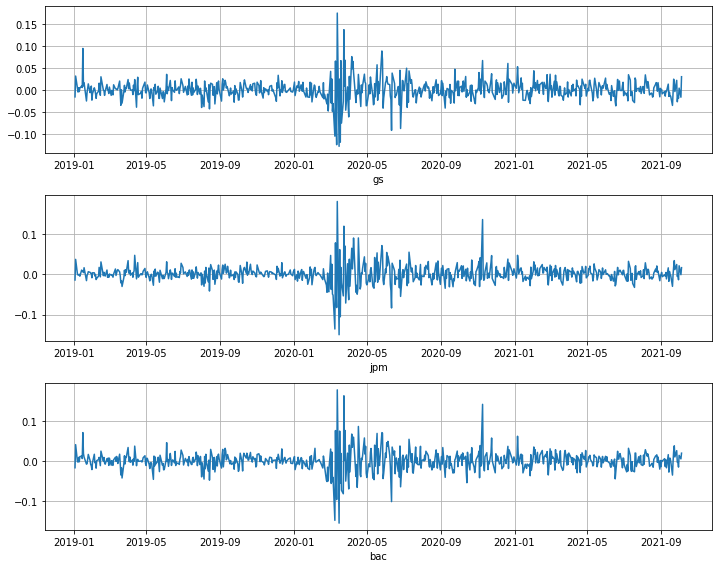

In [43]:
fig, ax = plt.subplots(r_df_adj.shape[1], figsize=(10,8))
for i, col in enumerate(r_df_adj.columns):
    ax[i].set_xlabel(col)
    ax[i].grid(True)
    ax[i].plot(r_df_adj[col])

fig.tight_layout()
plt.show()

<h3>
Asset Return Distributions
</h3>

<p>
The daily asset return distributions show "long tails" and non-zero means.
</p>

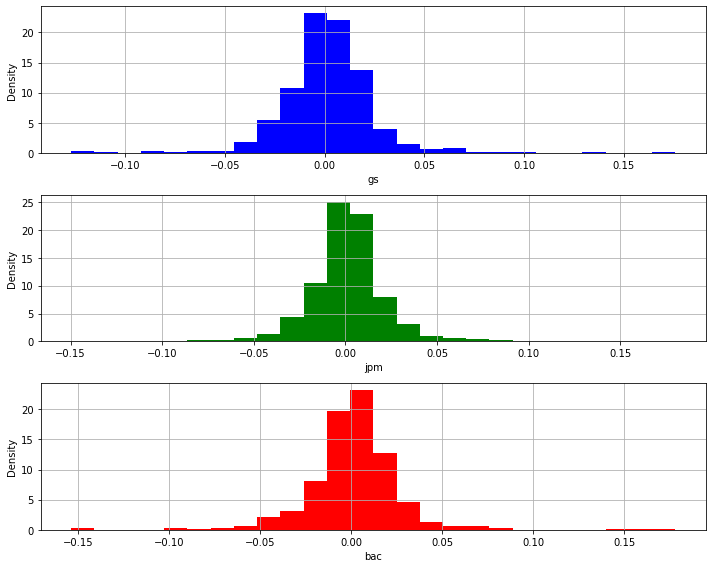

In [44]:
colors = ['b', 'g', 'r']
numBins = int(np.sqrt(r_df_adj.shape[0]))
fig, ax = plt.subplots(r_df_adj.shape[1], figsize=(10,8))
for i, col in enumerate(r_df_adj.columns):
    ax[i].set_xlabel( col )
    ax[i].set_ylabel('Density')
    ax[i].grid(True)
    ax[i].hist(r_df_adj[col], bins=numBins, density=True, facecolor=colors[i])

fig.tight_layout()
plt.show()

<h3>
Sharp Ratio
</h3>

$ Sharpe = \large \frac{E[R_a - R_{rf}]}{ \sqrt{var[R_a - R_{rf}]}} = \frac{E[R_a - R_{rf}]}{ \sigma_{ra}} = \frac{\mu_{ra}}{\sigma_{ra}} $

$ R_a$ is the asset return
$ R_{rf}$ is the risk-free return (e.g., in this case the 13-week US Treasury bill).
$ R_a - R_{rf}$ is the excess return over the risk-free rate.

<p>
The return values used here are daily return values. The Sharpe ratio is usually expressed
as a yearly value.  There are 253 trading days in a year. To convert the daily Sharpe ratio
to a yearly Sharpe ratio:
</p>

$ Sharpe_{year} = \large \frac{\mu_{ra} \times 253}{ \sigma_{ra} \times \sqrt{253}} =  \frac{\mu_{ra} \times 253}{ \sigma_{ra} \times \sqrt{253}} \times \frac{\sqrt{253}}{\sqrt{253}} =  \frac{\mu_{ra}}{\sigma_{ra}} \times \sqrt{253} $

<p>
There is a discussion on Stack Exchange about <a href="https://quant.stackexchange.com/questions/2260/how-to-annualize-sharpe-ratio">
annualizing the Sharpe ratio</a>.  A paper by Andrew Lo,
<a href="https://www.researchgate.net/publication/228139699_The_Statistics_of_Sharpe_Ratios">The Statistics of Sharpe Ratios</a>
is mentioned. Prof. Lo makes the point that because there is often serial correlation in returns
annualizing the Sharpe ratio in this way may yield a result that differs from the "correct"
value by significant amounts.  Unfortunately properly annualizing the Sharpe ratio is complicated
and beyond the scope of what I want to do here.
</p>

<h4>
Interpreting the Sharpe Ratio
</h4>
<p>
From <a href="https://www.businessinsider.com/sharpe-ratio">How the Sharpe Ratio is Calculated</a>
</p>
<ul>
<li>Under 1.0 is considered bad</li>
<li>1.0 is considered acceptable or good</li>
<li>2.0 or higher is rated as very good</li>
<li>3.0 or higher is considered excellent</li>
</ul>

In [45]:
# the risk free rate is reported as a yearly percentage return (e.g., 2 percent),
# so divide by 100.
rf_daily = (rf_prices_adj/100.0) / 365.00

trading_days = 253

rf_daily = rf_daily[rf_daily.columns[0]]

"""
Calculate the yearly Sharpe ratios for the assets
"""
sharpe_df: pd.DataFrame = pd.DataFrame()
for end in range(r_df_adj.shape[0], 0, -trading_days):
    start = end - trading_days
    if (start > 0):
        ret_year = r_df_adj[start:end]
        rf_year = rf_daily[start:end]
        sharpe_ratio = calc_sharpe_ratio(ret_year, rf_year)
        sharpe_ratio_year = sharpe_ratio * np.sqrt( trading_days )
        sharpe_df = sharpe_df.append(sharpe_ratio_year)
    else:
        break

<h3>
Yearly Sharpe Ratio
</h3>

<p>
The negative Sharpe ratios are a result of the fact that the mean return for the
Sharpe ratio period was negative.
</p>

In [46]:
print(tabulate(sharpe_df, headers=['Date range', *sharpe_df.columns], tablefmt='fancy_grid'))

╒═════════════════════════╤═════════╤════════════╤════════════╕
│ Date range              │      gs │        jpm │        bac │
╞═════════════════════════╪═════════╪════════════╪════════════╡
│ 2020-10-01 : 2021-10-05 │ 2.64963 │  2.37215   │  2.20966   │
├─────────────────────────┼─────────┼────────────┼────────────┤
│ 2019-09-27 : 2020-09-30 │ 0.217   │ -0.0655502 │ -0.0246391 │
╘═════════════════════════╧═════════╧════════════╧════════════╛


<h3>
References
</h3>

<ul>
<li>LaTex References. Jupyter notebooks use LaTex markup for equations
<ul>
<li><a href="https://artofproblemsolving.com/wiki/index.php/LaTeX:Symbols">LaTex Symbols (Art of Problem Solving)</a></li>
<li><a href="https://artofproblemsolving.com/wiki/index.php/LaTeX:Commands">LaTex Commands (Art of Problem Solving)</a></li>
</ul>
</li>

</ul>
